In [1]:
import json
import pandas as pd
import glob

import sys

import random
import tomotopy as tp
sys.path.append("C:/Users/yuuta/Documents/fashion")

from utils.util import filter_basic_items, is_target_category
from utils.util import calc_roc_auc
from utils.infer import topic_model_infer
from utils.util import open_json

c:\Users\yuuta\anaconda3\envs\fashion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\yuuta\anaconda3\envs\fashion\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yuuta\anaconda3\envs\fashion\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import importlib
import utils
importlib.reload(utils.infer)

<module 'utils.infer' from 'C:\\Users/yuuta/Documents/fashion\\utils\\infer.py'>

In [3]:
negative_path = glob.glob(
    "C:/Users/yuuta/Documents/fashion/model_learning/compatibility/data/negative_coordinates/**.json"
    # "C:/Users/yuuta/Documents/fashion/model_learning/compatibility/data/negative_coordinates_random/**.json"
    # "C:/Users/yuuta/Documents/fashion/data/test/**/*.json"
    # negative_coordinates_random
)
positive_path = glob.glob(
    # "C:/Users/yuuta/Documents/fashion/data/train/**/*.json"
    "C:/Users/yuuta/Documents/fashion/data/test/**/*.json"
)

In [4]:
with open(
    "C:/Users/yuuta/Documents/fashion/data/attributes_test.json",
    encoding="shift-jis"
) as f:
    to_attributes = json.load(f)

with open(
    "C:/Users/yuuta/Documents/fashion/data/attributes_train.json",
    encoding="shift-jis"
) as f:
    to_attributes_2 = json.load(f)

to_attributes = {**to_attributes, **to_attributes_2}



In [5]:
mdl = tp.LDAModel.load(
    "C:/Users/yuuta/Documents/fashion/model_learning/topic_model/models/lda.bin"
)
# mdl = tp.CTModel.load(
#     "C:/Users/yuuta/Documents/fashion/model_learning/topic_model/models/ctm.bin"
# )
# mdl = tp.MGLDAModel.load(
#     "C:/Users/yuuta/Documents/fashion/model_learning/topic_model/models/MGLDA.bin"
# )

In [6]:
for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=10))

Top 10 words of topic #0
[('shoes_geo', 0.05892040953040123), ('tops_Silk', 0.05633905157446861), ('shoes_plain', 0.0532621294260025), ('shoes_Black', 0.046146754175424576), ('bottoms_Blue', 0.04549586772918701), ('tops_Denim', 0.038439661264419556), ('tops_plainbottoms_Silk', 0.03178286552429199), ('tops_plainbottoms_Denim', 0.03130209818482399), ('tops_Wool', 0.03064381331205368), ('tops_White', 0.02626512013375759)]
Top 10 words of topic #1
[('bottoms_Silk', 0.10476075857877731), ('shoes_geo', 0.05496559292078018), ('shoes_Black', 0.04259951785206795), ('shoes_plain', 0.03865671157836914), ('tops_White', 0.03354209288954735), ('bottoms_plaintops_Silk', 0.029764719307422638), ('bottoms_Beige', 0.029709575697779655), ('tops_plainshoes_Silk', 0.02932356670498848), ('bottoms_Gray', 0.024953391402959824), ('tops_Beige', 0.022444332018494606)]
Top 10 words of topic #2
[('bottoms_Denim', 0.09622325003147125), ('bottoms_Blue', 0.07847441732883453), ('shoes_geo', 0.05021021515130997), ('shoe

In [7]:
print(len(negative_path), len(positive_path))

10000 53072


In [8]:
negative_path = random.sample(negative_path, 10000)
positive_path = random.sample(positive_path, 20000)

In [9]:
topic_model_score = []
labels = []

# ポジティブなもの
p_score = 0
p_cnt = 0
for fp in positive_path:
    json_dict = open_json(fp)
    items = filter_basic_items(json_dict["items"])
    # items = list(filter(is_target_category, json_dict["items"]))
    attributes = []
    if len(items) != 3:
        continue
    for item in items:
        try:
            itemId = str(item["itemId"])
        except Exception as e:
            print(fp, " : ", e)
            continue
        attr = to_attributes[itemId]
        attributes += attr
    score = topic_model_infer(mdl, attributes)
    topic_model_score.append(score)
    labels.append(0)
    p_cnt += 1
    p_score += score

In [10]:
# ネガティブなもの
n_score = 0
n_cnt = 0
for fp in negative_path:
    json_dict = pd.read_json(fp, encoding="shift-jis")
    # items = list(filter(is_target_category, json_dict["items"]))
    items = filter_basic_items(json_dict["items"])
    attributes = []
    if len(items) != 3:
        continue
    for item in items:
        try:
            itemId = str(item["itemId"])
        except Exception as e:
            print(fp, " : ", e)
            continue
        attr = to_attributes[itemId]
        attributes += attr
    if len(attributes) != 9:
        continue
    score = topic_model_infer(mdl, attributes)
    topic_model_score.append(score)
    labels.append(1)
    n_cnt += 1
    n_score += score

In [11]:
print(n_score / n_cnt, p_score / p_cnt)

-44.81099889907837 -44.629512505014


0.4906154081009566


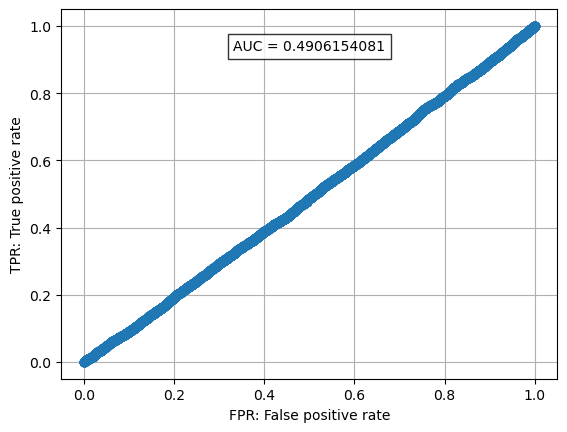

In [12]:
# t_auc = calc_roc_auc(labels, topic_model_score, "topic_model")
t_auc = calc_roc_auc(labels, topic_model_score, "ctm_random")

# print(t_auc, p_auc, len(labels))
print(t_auc)